In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
data_path = "../data/"

data_channel_path = os.path.join(data_path, "data_channel")
rgb_channel_path = os.path.join(data_channel_path, "incoherent_RGBchannels")
rgb_channel_train_path = os.path.join(rgb_channel_path, "train_incoherent_RGBChannels")
rgb_channel_same_val_path = os.path.join(rgb_channel_path, "testRawData_incoherent_sameProtocol")

### incoherent_RGBchannels

In [3]:
pattern = "Seg(\d+)_defocus(\-?\d+)"

In [4]:
segment_dict = {}
for segment_name in os.listdir(rgb_channel_train_path):
    segment_path = os.path.join(rgb_channel_train_path, segment_name)
    seg_dict = {}
    for image_name in os.listdir(segment_path):
        image_path = os.path.join(segment_path, image_name)
        match = re.search(pattern, image_name)
        if match:
            seg_num, defocus = int(match.group(1)), int(match.group(2))
            
        if seg_num not in seg_dict:
            seg_dict[seg_num] = []
        seg_dict[seg_num].append((defocus, image_path))
        
    segment_dict[segment_name] = seg_dict

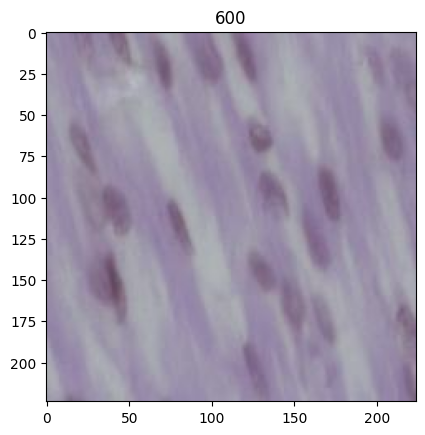

In [7]:
defocus, img_path = segment_dict["s93_l1"][2][np.random.randint(41)]
img = cv2.imread(img_path)
plt.title(defocus)
plt.imshow(img)

In [9]:
img.shape

(224, 224, 3)

In [19]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dft = cv2.dft(np.float32(img_gray), flags = cv2.DFT_COMPLEX_OUTPUT)

dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(
  dft_shift[:,:,0],
  dft_shift[:,:,1])
)

In [23]:
magnitude_spectrum.shape

(224, 224)

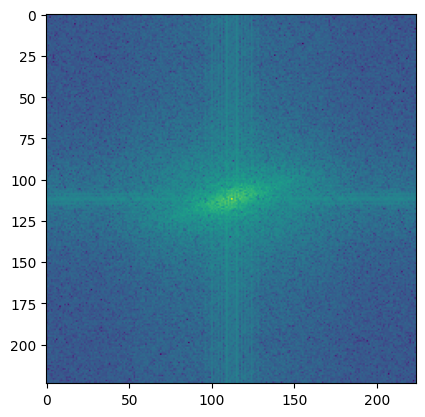

In [20]:
plt.imshow(magnitude_spectrum)

In [7]:
sorted(segment_dict["s93_l1"][2])

[(-10400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-10400.jpg'),
 (-9900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-9900.jpg'),
 (-9400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-9400.jpg'),
 (-8900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-8900.jpg'),
 (-8400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-8400.jpg'),
 (-7900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-7900.jpg'),
 (-7400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-7400.jpg'),
 (-6900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-6900.jpg'),
 (-6400,
  '../data/data_channel/incoherent_RGBchannels/train_

In [1]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate


with initialize(version_base=None, config_path="../configs/"):
    config = compose(overrides=["+db=mysql", "+dataset=rgb_dataset"])
    print(config)

{'dataset': {'rgb_data_path': '/home/dkrivenkov/program/autofocusing/data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels', 'same_data_path': '/home/dkrivenkov/program/autofocusing/data/data_channel/incoherent_RGBchannels/testRawData_incoherent_sameProtocol', 'diff_data_path': '/home/dkrivenkov/program/autofocusing/data/data_channel/incoherent_RGBchannels/testRawData_incoherent_diffProtocol', 'train_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'Seg(\\d+)_defocus(\\-?\\d+)', 'images_data': '???'}, 'val_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'Seg(\\d+)_defocus(\\-?\\d+)', 'images_data': '???'}, 'test_dataset': {'_target_': 'dataset.focusdataset.FocusingDataset', 'pattern': 'defocus(\\-?\\d+)', 'images_data': '???'}, 'train_dataloader': {'_target_': 'torch.utils.data.DataLoader', 'batch_size': 128, 'drop_last': True, 'num_workers': 10}, 'val_dataloader': {'_target_': 'torch.utils.data.DataLoader', 'batch_size

In [2]:
import sys
sys.path.append("..")

from dataset.data_module import DataModule
from dataset.utils import split_dataset

In [3]:
datamodule = DataModule(config)

In [4]:
datamodule.prepare_data()

In [5]:
images_train_rgb, images_val_rgb = split_dataset(datamodule.rgb_data)

In [6]:
len(images_train_rgb), len(images_val_rgb)

(102959, 25740)

In [18]:
img = cv2.imread(str(datamodule.same_data[-1]))

In [19]:
img.shape

(2048, 2448, 3)

In [18]:
import torch.nn as nn
from torchvision.models import vit_b_32, ViT_B_32_Weights
model = vit_b_32(weights=ViT_B_32_Weights.DEFAULT, progress=True)

In [1]:
import pyiqa
iqa_metric = pyiqa.create_metric('niqe', test_y_channel=True, color_space='rgb')

Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/niqe_modelparameters.mat" to /home/dkrivenkov/.cache/torch/hub/checkpoints/niqe_modelparameters.mat



  0%|          | 0.00/8.15k [00:00<?, ?B/s]